In [2]:
# 导入需要的处理数据和绘图的包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg') # 输出 svg 格式的矢量图
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Times']
}) # 使用 TeX 公式并调节字体

**步骤一：数据的整理和清洗**

首先利用 pandas 加载数据，并查看数据中是否存在缺失数据的问题。

In [3]:
# 加载数据
train_data = pd.read_csv('data/cs-training.csv')
test_data = pd.read_csv('data/cs-test.csv')
title = train_data.columns.values
# 给 csv 的第一列加上名字
title[0] = 'id'
train_data.columns = title
test_data.columns = title

In [4]:
# 查看是否存在缺失数据的问题
print(pd.isnull(train_data).sum(axis=0))
print(pd.isnull(test_data).sum(axis=0))

id                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64
id                                           0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEs

检查数据中的缺失值，可以看到月收入和亲人数目存在 na 值。

修复缺失值可以采用多种方法，例如将相关的行去掉。不过为了防止丢失信息，先要检验各列对于预测结果的重要性，这可以通过做统计检验来完成。我们先计算一下是否有收入、是否有亲人对结果是否有比较显著的影响。

In [4]:
# 检验是否有收入/是否有亲人对结果是否有显著影响
def check_p_value(col):
    from scipy.stats import ttest_ind
    train_data['No' + col] = pd.isnull(train_data[col])
    ab_testing = train_data.groupby('No' + col)
    # 利用 Student's t-test 对结果均值进行统计检验
    # 分组后计算是否有亲人的的违约率，看是否有显著差异
    no_income = ab_testing.get_group(True)['SeriousDlqin2yrs']
    has_income = ab_testing.get_group(False)['SeriousDlqin2yrs']
    _, p_value = ttest_ind(no_income, has_income)
    return p_value


print('MonthlyIncome: p-value is', check_p_value('MonthlyIncome'))
print('NumberOfDependents: p-value is', check_p_value('NumberOfDependents'))
train_data = train_data.drop(['NoMonthlyIncome', 'NoNumberOfDependents'],
                             axis=1)

MonthlyIncome: p-value is 1.5375333934991918e-16
NumberOfDependents: p-value is 6.869933917316381e-08


根据统计检验的 $p$-值可以发现二者对是否违约的影响非常显著（注意 $p<0.01$ 就已经算非常显著），所以不能去掉这种列。考虑到 na 一般是因为没有亲人/没有收入，我们采用补 0 的方法将这些缺失值消除。（当然，因为之后的机器学习方法梯度提升决策树可以处理 na 值，其实不管也可以。）

下面我们对数据进行可视化，查看数据的基本情况，观察一下是否有离群值等数据不均匀的问题。

In [5]:
# 对存在 NA 的列补 0
train_data = train_data.fillna(0)
test_data = test_data.fillna(0)
print(train_data.describe())

                  id  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  \
count  150000.000000     150000.000000                         150000.000000   
mean    75000.500000          0.066840                              6.048438   
std     43301.414527          0.249746                            249.755371   
min         1.000000          0.000000                              0.000000   
25%     37500.750000          0.000000                              0.029867   
50%     75000.500000          0.000000                              0.154181   
75%    112500.250000          0.000000                              0.559046   
max    150000.000000          1.000000                          50708.000000   

                 age  NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  \
count  150000.000000                         150000.000000  150000.000000   
mean       52.295207                              0.421033     353.005076   
std        14.771866                            

可以看到，有一些方差非常大。所以接下来要对数据进进一步预处理，主要的工作是解决数据的分布不够均匀的问题。先进一步画图查看情况。

In [6]:
# 数据离群值情况分析（输出数据扭斜的程度）
for col in train_data.columns.values:
    print(col, train_data[col].skew())

id 0.0
SeriousDlqin2yrs 3.4688570716991483
RevolvingUtilizationOfUnsecuredLines 97.63157448571562
age 0.18899454512676198
NumberOfTime30-59DaysPastDueNotWorse 22.597107559201046
DebtRatio 95.15779286552785
MonthlyIncome 119.90607913104274
NumberOfOpenCreditLinesAndLoans 1.2153137802048144
NumberOfTimes90DaysLate 23.087345471932874
NumberRealEstateLoansOrLines 3.482483993516935
NumberOfTime60-89DaysPastDueNotWorse 23.33174311951399
NumberOfDependents 1.6260587679259588


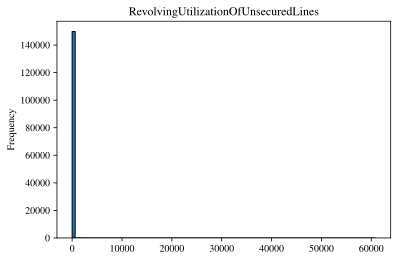

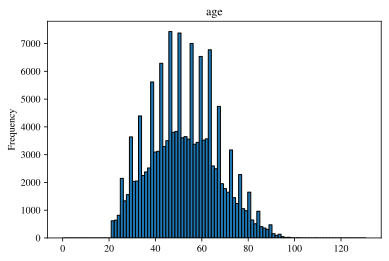

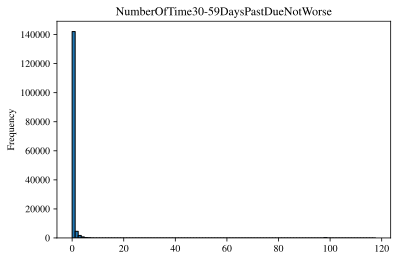

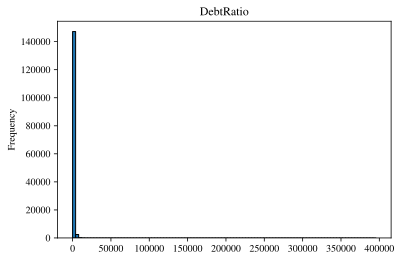

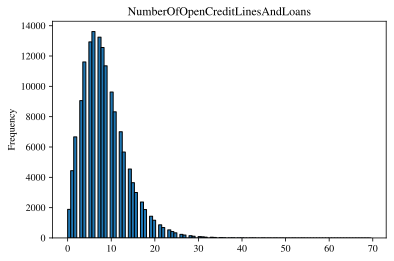

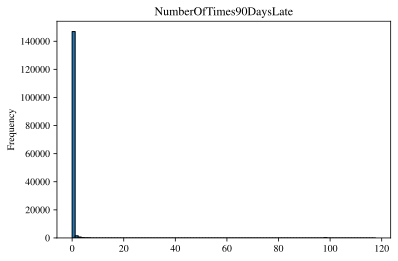

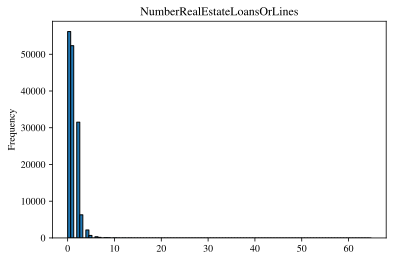

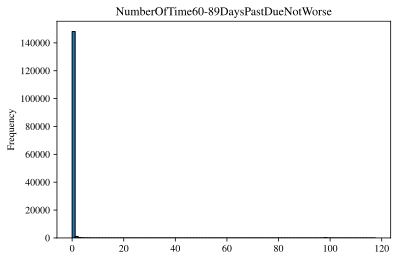

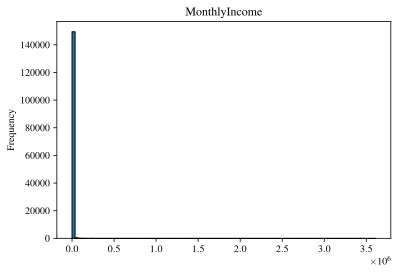

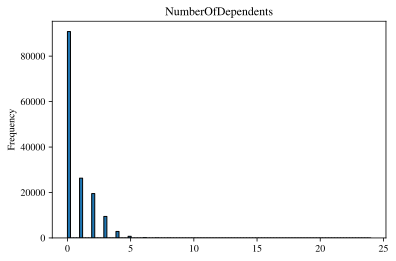

In [7]:
# 特征列的名称
useful_columns = [
    'RevolvingUtilizationOfUnsecuredLines', 'age',
    'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
    'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
    'MonthlyIncome', 'NumberOfDependents'
]


# 绘出数据 data 中 col 列分布的直方图
def draw_hist(data, col):
    r_max = data[col].max() * 1.2
    r_min = data[col].min() * 0.8
    plt.hist(data[col], bins=100, edgecolor='black', range=[r_min, r_max])
    plt.title(col)
    plt.ylabel('Frequency')
    plt.show()


# 检查各列分布情况
for col in useful_columns:
    draw_hist(train_data, col)

可以看出，有很多列存在离群值，即是最大值和最小值和平均值距离非常远，这和后面直方图的结果一致——有很多直方图大多数数据都集中在某个位置，只有几个数据在其它地方。比如剩余信用额度这一项，大多数都在 $[0, 1]$ 中，但有极少数非常大。根据这一特点，我们采用取对数的平滑化方法来减少离群值对后续统计分析的影响。另外也尝试过统计中常用 Box-Cox 平滑化方法（对数方法是它的一个特例），但效果不佳，就没有选用。

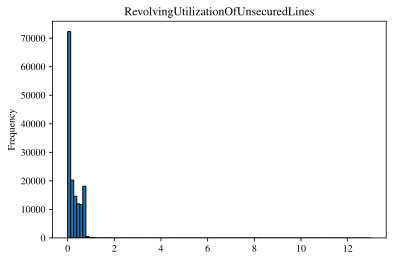

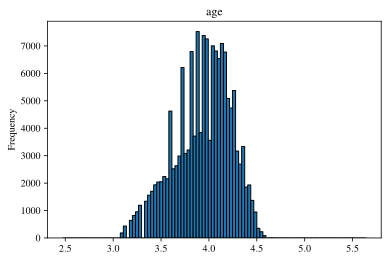

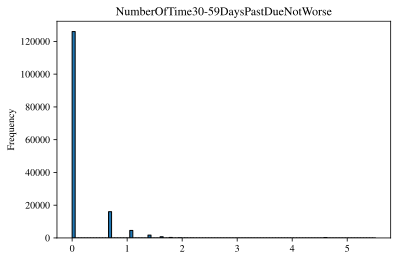

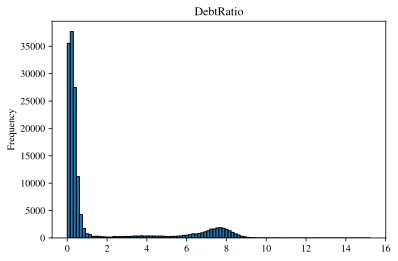

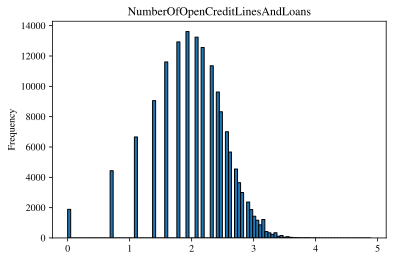

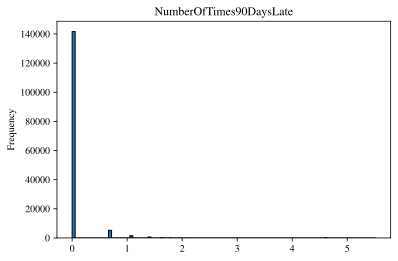

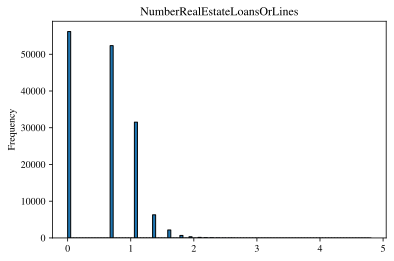

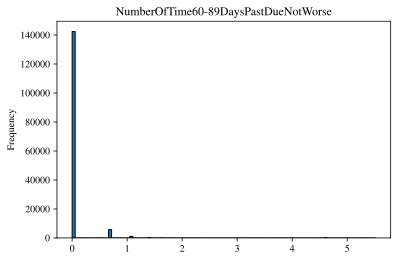

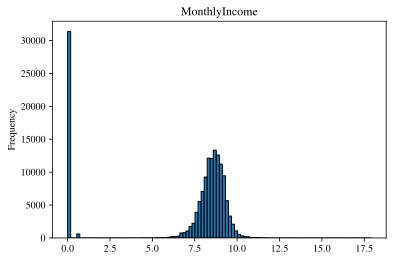

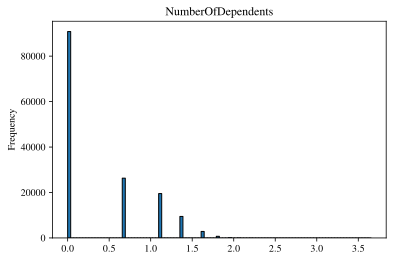

id -4.313695714785572e-06
SeriousDlqin2yrs 3.4693132123714467
RevolvingUtilizationOfUnsecuredLines 11.704853714966541
age -0.43859185865674605
NumberOfTime30-59DaysPastDueNotWorse 4.272316985089344
DebtRatio 1.74905364348665
MonthlyIncome -1.2919915404540359
NumberOfOpenCreditLinesAndLoans -0.7331759920681269
NumberOfTimes90DaysLate 8.81025058992004
NumberRealEstateLoansOrLines 0.23874763286948805
NumberOfTime60-89DaysPastDueNotWorse 10.605392190758494
NumberOfDependents 0.876386762451522


In [8]:
# 应先去掉几个没有实际用途的年龄
outliers = [0, 99, 100, 101]
for o in outliers:
    train_data = train_data[train_data['age'] != o]


# 取对数平滑，注意要先加 1 以免出现 nan
def smoothing(data):
    for col in useful_columns:
        data[col] = np.log(data[col].values + 1)


smoothing(train_data)
smoothing(test_data)

# 重新画出直方图，检查平滑化效果
for col in useful_columns:
    draw_hist(train_data, col)

for col in train_data.columns.values:
    print(col, train_data[col].skew())

经过上述整理之后，可以看到数据的分布不均匀程度降低了。

**步骤二：特征工程**

特征工程的第一步是通过绘制散点图，检查线性相关性，尝试采用更好的特征。首先检验一下相关系数（包括各特征相互之间的关联系数和同违约概率的关联系数），并绘图。

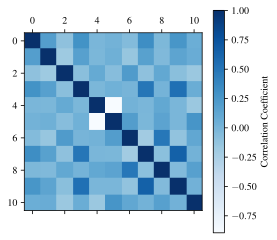

和违约概率最线性相关的五个特征
['NumberOfTimes90DaysLate' 'NumberOfTime30-59DaysPastDueNotWorse'
 'NumberOfTime60-89DaysPastDueNotWorse'
 'RevolvingUtilizationOfUnsecuredLines' 'age']

线性相关关系最大的特征对
DebtRatio NumberRealEstateLoansOrLines
DebtRatio NumberOfDependents
NumberOfTimes90DaysLate NumberOfTime60-89DaysPastDueNotWorse
NumberRealEstateLoansOrLines NumberOfDependents
MonthlyIncome NumberOfOpenCreditLinesAndLoans


In [9]:
corr = train_data.drop('id', axis=1, inplace=False).corr(method='pearson')
# 画出相关系数图
plt.matshow(corr, cmap=plt.cm.Blues)
plt.colorbar(label='Correlation Coefficient')
plt.show()

labels = np.array(corr.iloc[0, 1:].index)
# 输出和违约概率最线性相关的五个特征
print('和违约概率最线性相关的五个特征')
idx = np.abs(corr.iloc[0])[1:].argsort()[-5:][::-1]
print(labels[idx])

print()

# 根据热力图给出线性相关关系最大的特征对
print('线性相关关系最大的特征对')
max_pairs = [(3, 7), (3, 9), (6, 8), (7, 9), (4, 5)]
for p in max_pairs:
    print(labels[p[0]], labels[p[1]])

以上最“重要”的五个特征分为两类，第一种是历史违约记录，第二种是年龄和债务情况，它们将进一步在后面被利用。

线性相关关系最大的几对很容易理解，例如债务比高则债务笔数也多（正相关）；收入高的则债务笔数低（负相关）；违约到 60 天之后也很可能违约到 90 天以上（正相关），等等。

不过在这之前我们可以发现，从上面代码的输出结果来看，如果仅仅简单直接计算相关系数，几乎所有的特征和结果的线性相关性都不太高。我们还要进一步考虑非线性关系。以下我们用另外一个统计相关性的方法，称为 PPS 分数（预测能力分数）。它直接交叉验证一个决策树并利用 $F_1$ 值来刻画相关性。

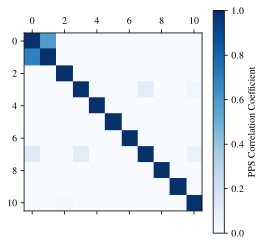

最能预测违约概率的五个特征
['RevolvingUtilizationOfUnsecuredLines' 'age'
 'NumberRealEstateLoansOrLines' 'NumberOfTimes90DaysLate'
 'NumberOfTime60-89DaysPastDueNotWorse']

PPS 分数最大的特征对
NumberOfOpenCreditLinesAndLoans NumberRealEstateLoansOrLines
NumberOfOpenCreditLinesAndLoans age
NumberRealEstateLoansOrLines age


In [10]:
import ppscore as pps

# 得到 PPS 系数
pps_corr = pps.matrix(train_data.drop(
    'id', axis=1, inplace=False))[['x', 'y',
                                   'ppscore']].pivot(columns='x',
                                                     index='y',
                                                     values='ppscore')
# 画出 PPS 相关系数图
plt.matshow(pps_corr, cmap=plt.cm.Blues)
plt.colorbar(label='PPS Correlation Coefficient')
plt.show()

labels = np.array(pps_corr.iloc[8].index)
# 输出最能预测违约概率的五个特征
print('最能预测违约概率的五个特征')
idx = np.abs(pps_corr.iloc[8]).argsort()[-6:][::-1]
print(labels[idx][labels[idx] != 'SeriousDlqin2yrs'])

print()

# 根据热力图给出线性相关关系最大的特征对
print('PPS 分数最大的特征对')
max_pairs = [(3, 7), (3, 10), (7, 10)]
for p in max_pairs:
    print(labels[p[0]], labels[p[1]])

上面分析指出，$\text{RevolvingUtilizationOfUnsecuredLines}$、$\text{age}$ 对违约概率的预测是很重要的，这和线性相关度分析得出的结论基本一致。最能预测违约概率的五个特征和违约概率最线性相关的五个特征也是基本一致的。后续机器学习给出的特征重要性还尤其指出了 $\text{RevolvingUtilizationOfUnsecuredLines}$ 和 $\text{age}$ 的地位。

从 PPS 分数来看，各特征之间没有很强的关系。鉴于我们要用到的机器学习方法会自动筛选特征，因此我们不会因为特征之间的关联而删除数据。

在上面整体分析的基础上，我们挑选一些更重要的特征进行仔细分析。首先，对一些具有离散值的特征进行先平均再线性回归的方法进行分析，并找出最好的非线性相关的幂次。具体地说，对于特征 $x$，我们希望检查它取每个值的时的平均情况和违约概率是否明显线性相关性，并找出在哪个 $p \in \mathbb R$ 时，$x^p$ 和违约概率的线性相关度最高。进行这一工作的原因是 $\text{age}$ 和违约概率的线性相关度并不高，但预测能力极强（图中深色），说明可以通过非线性关系进一步处理。

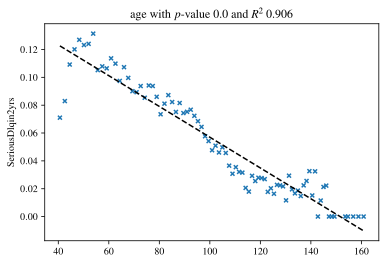

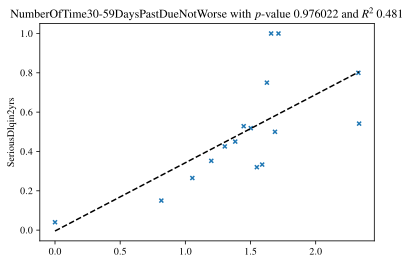

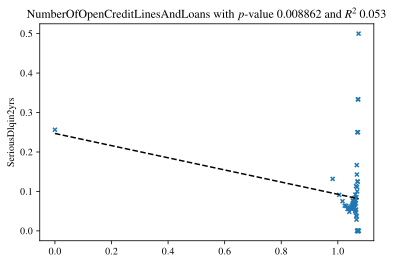

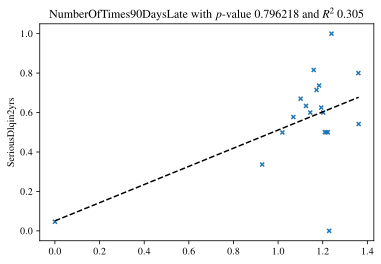

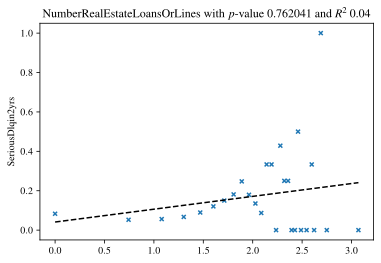

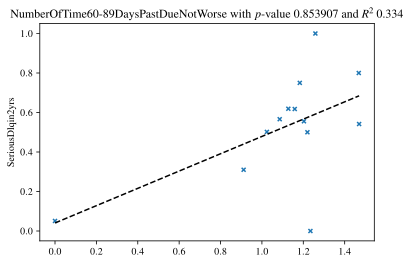

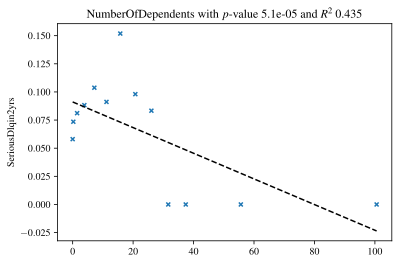

{'age': 3.28, 'NumberOfTime30-59DaysPastDueNotWorse': 0.56, 'NumberOfOpenCreditLinesAndLoans': 0.05, 'NumberOfTimes90DaysLate': 0.2, 'NumberRealEstateLoansOrLines': 0.81, 'NumberOfTime60-89DaysPastDueNotWorse': 0.25, 'NumberOfDependents': 4.14}


In [11]:
# 绘制散点图，同时利用简单的线性回归画出趋势线
def regression_plot(x, y, title='', ylabel='SeriousDlqin2yrs'):
    coef = np.polyfit(x, y, 1)
    poly1d_fn = np.poly1d(coef)
    plt.scatter(x, y, marker='x', s=16)
    plt.plot(x, poly1d_fn(x), c='black', linestyle='dashed')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


# 以下对各特征可能的^幂次和结果的相关度进行搜索
# 检查是否有明显的线性相关关系，并选出最佳幂次
power_list = np.linspace(0, 5, 100)


def regression(col):
    import statsmodels.api as sm
    # 根据所选特征进行分组，要求所选分组取整数值（否则最后取平均无太大），然后将相同特征的违约概率平均
    grouped = train_data.groupby(col)
    grouped = grouped['SeriousDlqin2yrs'].aggregate([np.mean,
                                                     'count']).reset_index()
    max_r = 0
    good_p = power_list[0]
    pv = 1
    y = grouped['mean']
    # 对平均违约概率和特征的某个幂次进行线性回归，挑选相关度最高的幂次
    for i, p in enumerate(power_list):
        x = np.power(grouped[col], p)
        x = sm.add_constant(x)
        result = sm.OLS(y, x).fit()
        if result.rsquared > max_r:
            max_r = result.rsquared
            good_p = power_list[i]
            pv = result.pvalues[0]
    x = np.power(grouped[col], good_p)

    # 画出散点图和趋势线以供检查
    regression_plot(x=x,
                    y=y,
                    title=col + ' with $p$-value ' + str(round(pv, 6)) +
                    ' and $R^2$ ' + str(round(max_r, 3)))
    return round(good_p, 2)


# 取值为整数的特征
integer_columns = [
    'age', 'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfDependents'
]
power_dict = {}
# 选出最佳幂次
for col in integer_columns:
    power_dict[col] = regression(col)

print(power_dict)

经过上述散点图和回归可以发现，和违约概率具有比较强线性相关关系的是年龄 $\text{age}^{3.28}$。其它特征虽然基本没有线性关系，但注意到存在的贷款笔数和违约概率有先负相关，后正相关的类似于二次曲线的关系。由此启发，我们还要看看这些直觉上可能存在“单峰”规律的特征是否可以用二次曲线刻画相关性。

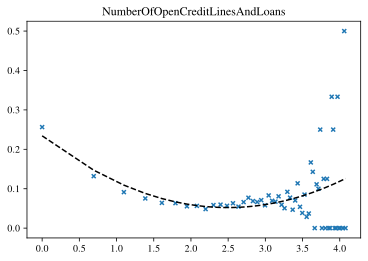

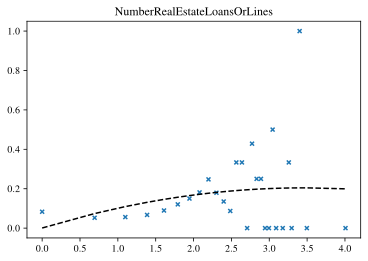

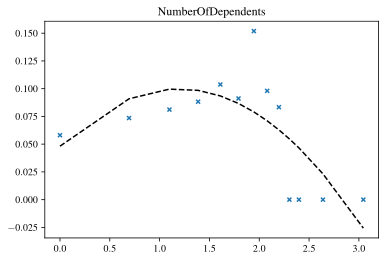

{'NumberOfOpenCreditLinesAndLoans': poly1d([ 0.02929883, -0.14602521,  0.23412332]), 'NumberRealEstateLoansOrLines': poly1d([-0.01695824,  0.11757031,  0.00054356]), 'NumberOfDependents': poly1d([-0.03651163,  0.08690534,  0.04818554])}


In [12]:
# 对于可能存在先增后见或先减后增的特征，用二次曲线拟合
def second_order_regression(col):
    # 先分组，再取平均
    grouped = train_data.groupby(col)
    grouped = grouped['SeriousDlqin2yrs'].aggregate([np.mean,
                                                     'count']).reset_index()
    x = grouped[col]
    y = grouped['mean']
    # 二次曲线拟合并作图
    coef = np.polyfit(x, y, 2)
    poly1d_fn = np.poly1d(coef)
    plt.scatter(x, y, marker='x', s=16)
    plt.plot(x, poly1d_fn(x), c='black', linestyle='dashed')
    plt.title(col)
    plt.show()
    return poly1d_fn


second_trans = {}
# 这些是可能存在先增后减或先减后增的列
second_order_columns = [
    'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
    'NumberOfDependents'
]

for col in second_order_columns:
    second_trans[col] = second_order_regression(col)

print(second_trans)

根据上面给出的分析结果可以看出 $\text{NumberOfOpenCreditLinesAndLoans}$ 对二次曲线拟合的效果比较好。我们利用这条二次曲线变换原特征并加到数据集中。

以下添加前面分析出的具有意义的新特征。其中 $\text{age}$ 选用优化过的线性相关度 $R^2$ 最高的次幂；$\text{NumberOfOpenCreditLinesAndLoans}$ 采用二次曲线拟合训练集后重新作为特征加入。其它优化过的特征因为从上面看到的拟合效果不明显而不作更多的变换。

另外很重要的是，我们还根据前面的相关性分析，对已有特征作了具有实际意义的变换加到数据集中，这包括每月净收入、家庭每人平均收入等等，这些特征中的一些将在后续发挥关键的作用。

In [13]:
# 根据上面作图分析得出新特征
power_dict = {'age': 3.28}
for key, value in power_dict.items():
    train_data[key + '_pow'] = train_data[key].values**value
    test_data[key + '_pow'] = test_data[key].values**value

second_trans = {
    'NumberOfOpenCreditLinesAndLoans':
    np.poly1d([0.02929883, -0.14602521, 0.23412332])
}
for key, value in second_trans.items():
    train_data[key + '_second'] = value(train_data[key])
    test_data[key + '_second'] = value(test_data[key])

# 下面是一些符合直觉、有实际意义的新特征，可以供训练时筛选
# 每个家庭成员的收入
train_data['IncomePerPerson'] = train_data['MonthlyIncome'] / (
    train_data['NumberOfDependents'] + 1)
test_data['IncomePerPerson'] = test_data['MonthlyIncome'] / (
    test_data['NumberOfDependents'] + 1)

# 总违约数
train_data[
    'NumOfPastDue'] = train_data['NumberOfTimes90DaysLate'] + train_data[
        'NumberOfTime60-89DaysPastDueNotWorse'] + train_data[
            'NumberOfTime30-59DaysPastDueNotWorse']
test_data['NumOfPastDue'] = test_data['NumberOfTimes90DaysLate'] + test_data[
    'NumberOfTime60-89DaysPastDueNotWorse'] + test_data[
        'NumberOfTime30-59DaysPastDueNotWorse']

# 每月债务的绝对值
train_data[
    'MonthlyDebt'] = train_data['DebtRatio'] * train_data['MonthlyIncome']
test_data['MonthlyDebt'] = test_data['DebtRatio'] * test_data['MonthlyIncome']

# 除房地产外的信用贷款
train_data['NumOfOpenCreditLines'] = train_data[
    'NumberOfOpenCreditLinesAndLoans'] - train_data[
        'NumberRealEstateLoansOrLines']
test_data['NumOfOpenCreditLines'] = test_data[
    'NumberOfOpenCreditLinesAndLoans'] - test_data[
        'NumberRealEstateLoansOrLines']

# 每个月的净收入
train_data[
    'MonthlyBalance'] = train_data['MonthlyIncome'] - train_data['MonthlyDebt']
test_data[
    'MonthlyBalance'] = test_data['MonthlyIncome'] - test_data['MonthlyDebt']

注意，以上对重要性的分析都是感性认识，主要是增加之后机器学习模型的可解释性。我们不必对特征进行人工筛选，之后要用到的梯度提升决策树会自动帮我们选择合适的特征，并为特征的重要性排序。

**步骤三：模型选择和训练**

考虑到金融数据通常噪音比较明显，因此我们应采用传统的机器学习方法进行训练，使用深度学习方法通常很容易造成过拟合。这里，我们将采用梯度提升决策树（Gradient Boosting，一种增强学习算法用于决策树）这一金融中流行的分类算法框架进行训练。注意需要调节超参数来避免过拟合，这包括 XGB 中的参数以及筛选特征用到的阈值。为了减少手工调节的麻烦，使用 hyperopt 包结合 bayesian optimization 方法和 5 分交叉验证自动调出。随后再将得到的超参数用于实际训练。

In [14]:
import xgboost as xgb

# 将训练集分为特征和标签两部分
train_y = train_data['SeriousDlqin2yrs']
train_X = train_data.drop(['SeriousDlqin2yrs', 'id'], axis=1, inplace=False)
test_X = test_data.drop(['SeriousDlqin2yrs', 'id'], axis=1, inplace=False)

# 制作 xgboost 使用的数据
train_dmatrix = xgb.DMatrix(data=train_X, label=train_y)

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# 定义可能的超参数搜索空间及其先验分布
space = {
    'eta': hp.uniform('eta', 0, 0.5),
    'max_depth': hp.quniform('max_depth', 3, 8, 1),
    'gamma': hp.uniform('gamma', 0, 10),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'sub_sample': hp.uniform('sub_sample', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1)
}


# 对于超参数 p，进行 5 分交叉验证，取验证集上 AUC 的平均值作为评价标准
def fit(p):
    params = {
        'gpu_id': 0,
        'tree_method': 'gpu_hist',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'eta': p['eta'],
        'max_depth': int(p['max_depth']),
        'sub_sample': p['sub_sample'],
        'colsample_bytree': p['colsample_bytree'],
        'gamma': p['gamma'],
        'reg_alpha': p['reg_alpha'],
        'reg_lambda': p['reg_lambda'],
        'min_child_weight': int(p['min_child_weight']),
        'verbosity': 0
    }
    xgb_cv = xgb.cv(dtrain=train_dmatrix,
                    params=params,
                    nfold=5,
                    metrics='auc',
                    num_boost_round=1000,
                    early_stopping_rounds=30)
    # print('AUC: {}'.format(xgb_cv[-1:].values[0][2]))
    return {'loss': -xgb_cv[-1:].values[0][2], 'status': STATUS_OK}


trials = Trials()
# 交叉验证搜索 1000 次选择最佳超参数
best_hyperparams = fmin(fn=fit,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=1000,
                        trials=trials)
print('最佳超参数\n', best_hyperparams)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [4:18:15<00:00, 15.50s/trial, best loss: -0.8665370474098882]
最佳超参数
 {'colsample_bytree': 0.515950038908963, 'eta': 0.04416136184305465, 'gamma': 0.6740388867700878, 'max_depth': 5.0, 'min_child_weight': 6.0, 'reg_alpha': 3.278540392393092, 'reg_lambda': 9.083185522332887, 'sub_sample': 0.7711747371670172}


根据以上的交叉验证结果，选择搜索到的超参数再次训练（上面已经打印出来），并绘制 feature importance 观测各种特征对信用卡评分的重要性。

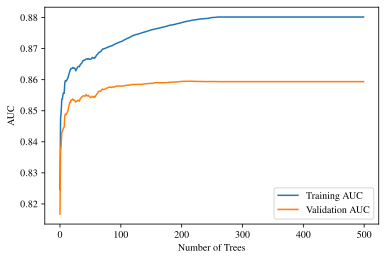

In [15]:
train = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns)
test = xgb.DMatrix(test_X, feature_names=test_X.columns)

# 将前面搜索得到的最好参数设为训练时的参数
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams['min_child_weight'] = int(
    best_hyperparams['min_child_weight'])
xgb_params = dict(
    **{
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'verbosity': 0,
        'gpu_id': 0,
        'tree_method': 'gpu_hist'
    }, **best_hyperparams)

# 在最终训练之前还要防止过拟合问题，先选择最好的 num_boost_round
# 这里为了方便就使用留一法验证
from sklearn.model_selection import train_test_split

rX_train, rX_test, ry_train, ry_test = train_test_split(train_X,
                                                        train_y,
                                                        test_size=0.2)
d_round_train = xgb.DMatrix(rX_train, ry_train)
d_round_eval = xgb.DMatrix(rX_test, ry_test)
results = {}
round_model = xgb.train(xgb_params,
                        d_round_train,
                        evals=[(d_round_train, 'train'),
                               (d_round_eval, 'valid')],
                        num_boost_round=500,
                        verbose_eval=False,
                        evals_result=results)

plt.plot(results['train']['auc'], label='Training AUC')
plt.plot(results['valid']['auc'], label='Validation AUC')
plt.xlabel('Number of Trees')
plt.ylabel('AUC')
plt.legend()
plt.show()

由上面的验证可以看到，随着训练轮数（决策树数目）的增加，最终的泛化性能先变好后变差，选择轮数为 300 比较合理。

Train accuracy 0.9397347770140079
Train AUC 0.8773738836844558


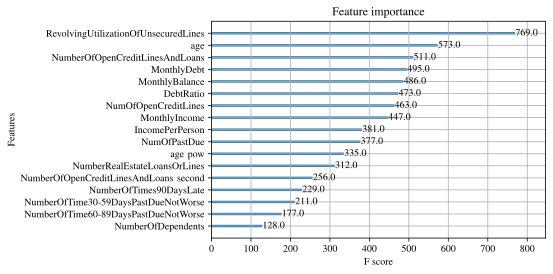

In [16]:
# 开始训练并保存模型
final_model = xgb.train(xgb_params, train, num_boost_round=300)
final_model.save_model('model.json')
# 查看在训练集上的准确性
ypred_train = final_model.predict(train)
print('Train accuracy', np.mean((ypred_train >= 0.5) == train_y))
from sklearn.metrics import roc_auc_score

print('Train AUC', roc_auc_score(train_y, ypred_train))
ypred = final_model.predict(test)

# 评估各个因素对信用卡评分的重要程度
xgb.plot_importance(final_model)
plt.show()

**各特征对于信用卡评分的重要性**

最重要的特征前五名为：信用卡总余额和个人信用额度、年龄、债务笔数、每月债务以及每月净收入。其中每月净收入是特征工程新添加的特征，它具有很高的意义。利用特征变换给出的信息也有一定的作用。可以看出，一个人的信用表现最主要的还是取决于他的“硬实力”，主要表现为还款能力。而过往的信用表现虽然也很重要，但是相对而言没有绝对的还款能力重要。

机器学习模型给出的特征重要性和前面部分的简单统计分析一致。比如，线性相关度高的特征重要性尤其高。其次，相互之间的关联度比较高的特征，则一般只选入了一个用于预测违约概率。

**步骤四：测试、评分和可视化**

为了将预测违约的违约概率转化为信用卡评分，我们取得了一个简单的数据集——流行的 FICO 信用卡评分和违约概率的[表格](https://www.fico.com/sites/default/files/inline-files/Truncation_Bias_and_Credit_Score_Modeling_Final.pdf)。

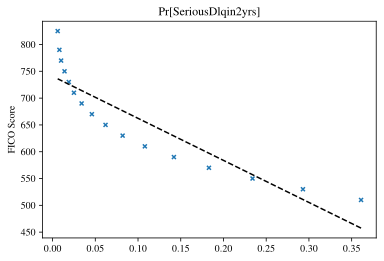

In [17]:
fico_data = pd.read_csv('data/default-score.csv')
X = fico_data['rate']
y = fico_data['score']

# 将违约率和 FICO 分数进行散点作图
regression_plot(x=X, y=y, title='Pr[SeriousDlqin2yrs]', ylabel='FICO Score')

从上面的图中可以看出，违约概率和信用分大致有一个对数或者指数的关系。以下将使用

$$\text{信用分} = a \cdot \log \left(\frac{1}{\text{违约概率}}-1 \right)+b$$

这个模型。这里 $\log$ 括号中的项在统计中有实际意义，称为 OR 值（odds ratio，正事件和反事件的概率比，刻画的是相对风险）。下面用这个模型重新拟合信用分和违约概率的关系。

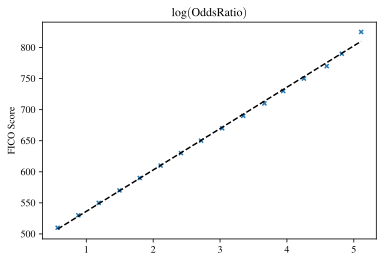

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     6407.
Date:                Mon, 16 May 2022   Prob (F-statistic):           4.91e-20
Time:                        19:41:04   Log-Likelihood:                -46.332
No. Observations:                  16   AIC:                             96.66
Df Residuals:                      14   BIC:                             98.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        469.7499      2.660    176.607      0.0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


In [18]:
import statsmodels.api as sm

# 重新变换数据后回归，并建立模型
regression_plot(x=np.log(1.0 / X - 1), y=y, title=r'$\log(\mathrm{OddsRatio})$', ylabel='FICO Score')
X = sm.add_constant(np.log(1.0 / X - 1))
result = sm.OLS(y, X).fit()
print(result.summary())

从回归结果的 $R^2$ 来看以上模型效果很好，由此可将前面的违约概率模型预测的概率转换为信用分，并得出最终的预测数据，以及测试集上信用分的分布等可视化结果。

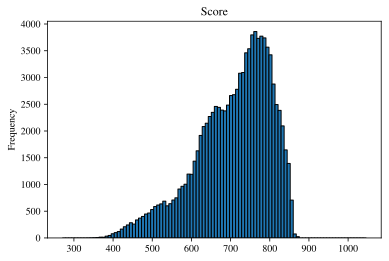

测试集中各信用分人群的分布
500~519 1.4%
520~539 1.6%
540~559 1.6%
560~579 2.2%
580~599 2.6%
600~619 3.5%
620~639 4.9%
640~659 5.5%
660~679 5.8%
680~699 6.0%
700~719 6.5%
720~739 7.5%
740~759 8.8%
760~779 9.2%
780~799 8.8%
800~819 7.1%
820~839 5.3%
840~859 2.9%
860~879 0.1%


In [19]:
# 给出模型在测试集上的预测信用分和预测违约概率
ypred_score = result.predict(sm.add_constant(np.log(1.0 / ypred - 1)))
yout = pd.DataFrame({'ID': test_data.id.values, 'Probability': ypred})
yout_score = pd.DataFrame({'ID': test_data.id.values, 'Score': ypred_score})
yout.to_csv('result.csv', index=False)
yout_score.to_csv('score.csv', index=False)

# 绘制测试集中信用分的分布
draw_hist(yout_score, 'Score')
score_ranges = np.arange(500, 900, 20)
print('测试集中各信用分人群的分布')
for i in range(len(score_ranges) - 1):
    l, r = score_ranges[i], score_ranges[i + 1] - 1
    percentage = np.mean(np.logical_and(ypred_score >= l, ypred_score <= r))
    print('{}~{}'.format(l, r), str(round(percentage * 100, 1)) + '%')

**简要的结论和评估**

我们所给出的在测试集上的违约概率的预测提交至 Kaggle 上后得到了 0.86910 的优秀的 AUC 分数（排行榜上最高为为 0.86955，第 5 名为 0.86913，第 10 名为 0.86891）。另外，经实际数据检验可以看出，我们对人群中信用分分布的评估和 FICO Score 在社会上统计结果也非常类似——向右扭斜的正态分布。可见我们的模型性能较好，且具有实际意义和可解释性（参看我们在特征工程部分的描述和 feature importance 的图）。